<center><h1> Darknet traffic dataset </h1> </center>

# Libraries importing and configuration

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipinfo
import json
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from category_encoders.hashing import HashingEncoder
from tqdm import tqdm

In [162]:
ipinfo_handler = ipinfo.getHandler("de30fe3213f197")

random_state = 42
dataset_folder = "dataset/" 

pd.options.mode.chained_assignment = None  # default='warn'
np.random.seed(random_state)
plt.rcParams['figure.figsize'] = (18,6)
plt.rcParams.update({'font.size': 15})

In [163]:
data = pd.read_csv(dataset_folder + "Darknet.CSV", low_memory=False)

# Dataset processing

## Labels duplicates correction

In [214]:
samples = data.copy()

traffic_labels = samples["Label"].unique()
print(traffic_labels)
traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Non-Tor' 'NonVPN' 'Tor' 'VPN']
['AUDIO-STREAMING' 'Browsing' 'Chat' 'Email' 'File-Transfer'
 'File-transfer' 'P2P' 'Video-Streaming' 'Audio-Streaming'
 'Video-streaming' 'VOIP']


In [215]:
samples['Label.1'].loc[samples['Label.1'] == 'AUDIO-STREAMING'] = 'Audio-Streaming'
samples['Label.1'].loc[samples['Label.1'] == 'File-transfer'] = 'File-Transfer'
samples['Label.1'].loc[samples['Label.1'] == 'Video-streaming'] = 'Video-Streaming'

traffic_type_labels = samples["Label.1"].unique()
print(traffic_type_labels)

['Audio-Streaming' 'Browsing' 'Chat' 'Email' 'File-Transfer' 'P2P'
 'Video-Streaming' 'VOIP']


## Labels grouping in Benign and Darknet

In [216]:
samples['Label'].loc[(samples['Label'] == 'Non-Tor') | (samples['Label'] == 'NonVPN')] = 'Benign'
samples['Label'].loc[(samples['Label'] == 'Tor') | (samples['Label'] == 'VPN')] = 'Darknet'

traffic_labels = samples["Label"].unique()
print(traffic_labels)

['Benign' 'Darknet']


## Timestamp feature extraction

In [217]:
hours = []
for timestamp in samples['Timestamp']:
    hora = int(timestamp.split()[1].split(':')[0])
    hours.append(hora)
samples['hour'] = hours
print(samples[['Timestamp', 'hour']][:5])

                Timestamp  hour
0  24/07/2015 04:09:48 PM     4
1  24/07/2015 04:09:48 PM     4
2  24/07/2015 04:09:48 PM     4
3  24/07/2015 04:09:48 PM     4
4  24/07/2015 04:09:45 PM     4


## Source and destination ips feature extraction

### 1-gram, 2-gram and 3-gram extraction

In [218]:
def create_grams(ip):
    parts = ip.split('.')
    one_gram = parts[0]
    two_gram = parts[0] + " " + parts[1]
    three_gram = parts[0] + " " + parts[1] + " " + parts[2]
    return one_gram, two_gram, three_gram

In [219]:
src_one_gram = []
src_two_gram = []
src_three_gram = []
dst_one_gram = []
dst_two_gram = []
dst_three_gram = []

for src_ip, dst_ip in zip(samples["Src IP"], samples["Dst IP"]): 
    src_one, src_two, src_three = create_grams(src_ip)
    src_one_gram.append(src_one)
    src_two_gram.append(src_two)
    src_three_gram.append(src_three)
    dst_one, dst_two, dst_three = create_grams(dst_ip)
    dst_one_gram.append(dst_one)
    dst_two_gram.append(dst_two)
    dst_three_gram.append(dst_three)

samples["src_ip_1gram"] = src_one_gram
samples["src_ip_2gram"] = src_two_gram
samples["src_ip_3gram"] = src_three_gram

samples["dst_ip_1gram"] = dst_one_gram
samples["dst_ip_2gram"] = dst_two_gram
samples["dst_ip_3gram"] = dst_three_gram

#print(samples[["Src IP","src_ip_1gram","src_ip_2gram","src_ip_3gram"]][200:205])
#print(samples[["Dst IP","dst_ip_1gram","dst_ip_2gram","dst_ip_3gram"]][:5])

### Ips details extraction

In [220]:
def get_ip_detail(ip, ip_dict, repeated):
    if ip not in ip_dict.keys():
        details = ipinfo_handler.getDetails(ip)
        ip_dict[ip] = details.all
    else:
        repeated += 1
    return repeated

def dump_ips(ip_dict, folder):
    j = json.dumps(ip_dict)
    f = open(folder+"ips_dict.json","w")
    f.write(j)
    f.close()

def load_ips(file):
    data = {}
    with open(file) as json_file:
        data = json.load(json_file)
    return data

In [221]:
ip_dict = load_ips("ips_dict.json")

In [222]:
ips = np.concatenate((samples["Src IP"].unique(), samples["Dst IP"].unique())) 
for i in tqdm(range(len(ips))):
    get_ip_detail(ips[i], ip_dict, 0)
dump_ips(ip_dict, "")

100%|██████████| 11111/11111 [00:00<00:00, 363826.59it/s]


In [223]:
ips_tuple = zip(samples["Src IP"], samples["Dst IP"])
dst_ip_country = []
src_ip_country = []
src_bogon = []
dst_bogon = []

for src_ip, dst_ip in tqdm(ips_tuple, total=len(samples["Src IP"])):
    if 'country' in ip_dict[dst_ip].keys():
        dst_ip_country.append(ip_dict[dst_ip]['country'])
    else:
        dst_ip_country.append("")
    if 'country' in ip_dict[src_ip].keys():
        src_ip_country.append(ip_dict[src_ip]['country'])
    else:
        src_ip_country.append("")
    if 'bogon' in ip_dict[dst_ip].keys():
        dst_bogon.append(ip_dict[dst_ip]['bogon'])
    else:
        dst_bogon.append(False)
    if 'bogon' in ip_dict[src_ip].keys():
        src_bogon.append(ip_dict[src_ip]['bogon'])
    else:
        src_bogon.append(False)
samples['src_ip_country'] = src_ip_country
samples['dst_ip_country'] = dst_ip_country
samples['src_bogon'] = src_bogon
samples['dst_bogon'] = dst_bogon

100%|██████████| 141530/141530 [00:00<00:00, 254606.48it/s]


## Irrelevant attributes extraction

In [327]:
model_samples = samples.copy()

del model_samples['Flow ID']
del model_samples['Timestamp']
del model_samples['Src IP']
del model_samples['Dst IP']

In [328]:
cols = np.concatenate((model_samples.columns[81:], model_samples.columns[:81]))
model_samples = model_samples[cols]

In [329]:
model_samples.columns

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram',
       'dst_ip_2gram', 'dst_ip_3gram', 'src_ip_country', 'dst_ip_country',
       'src_bogon', 'dst_bogon', 'Src Port', 'Dst Port', 'Protocol',
       'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Pac

## Categorical features encoding

In [330]:
hash_enc_cols = cols[1:7]
print(hash_enc_cols)
ord_enc_cols = ['src_ip_country','dst_ip_country']
print(ord_enc_cols)
one_hot_enc_cols = ['Label.1']
print(one_hot_enc_cols)

['src_ip_1gram' 'src_ip_2gram' 'src_ip_3gram' 'dst_ip_1gram'
 'dst_ip_2gram' 'dst_ip_3gram']
['src_ip_country', 'dst_ip_country']
['Label.1']


In [331]:
hash_enc = HashingEncoder(cols=hash_enc_cols, n_components=100).fit(model_samples)
model_samples = hash_enc.transform(model_samples)
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label.1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign,Audio-Streaming
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign,Audio-Streaming


In [332]:
ord_enc = OrdinalEncoder()
ord_enc.fit(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = ord_enc.transform(model_samples[ord_enc_cols])
model_samples[ord_enc_cols] = model_samples[ord_enc_cols].astype(int)
model_samples[ord_enc_cols].head() 

,src_ip_country,dst_ip_country
0,0,134
1,0,134
2,0,134
3,0,134
4,0,134


In [333]:
model_samples_l1 = model_samples.copy()
#new_columns = pd.get_dummies(model_samples[one_hot_enc_cols[0]], prefix='class')
#model_samples = pd.concat([model_samples, new_columns], axis=1)
del model_samples['Label.1']
model_samples.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
1,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
2,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
3,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Benign
4,0,0,0,0,0,0,0,0,0,0,...,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Benign


In [334]:
new_columns = pd.get_dummies(model_samples_l1['Label'], prefix='class')
model_samples_l1 = pd.concat([model_samples_l1, new_columns], axis=1)
del model_samples_l1['Label']
model_samples_l1.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label.1,class_Benign,class_Darknet
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Audio-Streaming,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Audio-Streaming,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Audio-Streaming,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00,Audio-Streaming,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15,Audio-Streaming,1,0


In [335]:
model_samples = model_samples.replace([np.inf, -np.inf], np.nan)
model_samples_l1 = model_samples_l1.replace([np.inf, -np.inf], np.nan)

In [336]:
model_samples = model_samples.dropna()
model_samples_l1 = model_samples_l1.dropna()
len(model_samples)

141483

## Numerical features scaling

In [337]:
real_columns = model_samples.columns[108:-9]
real_columns

Index(['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets',
       'Total Length of Fwd Packet', 'Total Length of Bwd Packet',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag C

In [338]:
model_samples[real_columns] = model_samples[real_columns].astype(np.float64)
model_samples[real_columns] = model_samples[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples[real_columns].dropna()

model_samples_l1[real_columns] = model_samples_l1[real_columns].astype(np.float64)
model_samples_l1[real_columns] = model_samples_l1[real_columns].replace([np.inf, -np.inf], np.nan)
model_samples_l1[real_columns].dropna()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
0,229.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1892.0,1047.0,0.0,20.0
1,407.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1987.0,1047.0,0.0,20.0
2,431.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2049.0,1047.0,0.0,20.0
3,359.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2008.0,1047.0,0.0,20.0
4,10778451.0,591.0,400.0,64530.0,6659.0,131.0,0.0,109.187817,22.283313,498.0,...,659.0,6605.0,0.0,65.0,0.0,6.0,1382.0,2320.0,581.0,20.0
5,421362.0,5.0,3.0,72.0,79.0,72.0,0.0,14.400000,32.199379,79.0,...,0.0,0.0,0.0,9.0,0.0,9.0,14600.0,913.0,1.0,20.0
6,119682119.0,488.0,487.0,89259.0,314105.0,1460.0,0.0,182.907787,360.042956,1460.0,...,44.0,9225.0,0.0,91.0,0.0,322.0,12108.0,9520.0,209.0,20.0
7,116996934.0,369.0,378.0,208796.0,34340.0,1460.0,0.0,565.842818,598.927808,1460.0,...,25.0,4949.0,0.0,279.0,0.0,45.0,21142.0,8323.0,268.0,20.0
8,100279453.0,61.0,60.0,14526.0,17870.0,996.0,0.0,238.131147,324.805505,1460.0,...,11.0,4300.0,0.0,120.0,0.0,147.0,2640.0,3346.0,31.0,20.0
9,119962833.0,3638.0,3157.0,254101.0,488658.0,190.0,0.0,69.846344,53.942584,1460.0,...,4427.0,6193.0,0.0,37.0,0.0,71.0,14600.0,5292.0,2775.0,20.0


In [339]:
df1 = model_samples[model_samples.isna().any(axis=1)]
model_samples = model_samples.drop(df1.index)

df1 = model_samples_l1[model_samples_l1.isna().any(axis=1)]
model_samples_l1 = model_samples_l1.drop(df1.index)

In [340]:
scaler = StandardScaler().fit(model_samples[real_columns])
model_samples[real_columns] = scaler.transform(model_samples[real_columns])
model_samples_l1[real_columns] = scaler.transform(model_samples_l1[real_columns])

In [341]:
model_samples[real_columns].head()

,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min
0,-0.546508,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.345303,-0.095141,-0.061219,0.589647
1,-0.546503,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.335704,-0.095141,-0.061219,0.589647
2,-0.546502,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.329439,-0.095141,-0.061219,0.589647
3,-0.546504,-0.063838,-0.044949,-0.034644,-0.028574,-0.321759,-0.498852,-0.316449,-0.379416,-0.292366,...,-0.052228,-0.043209,-0.634075,-0.313203,0.0,-0.413046,-0.333582,-0.095141,-0.061219,0.589647
4,-0.263585,0.184194,0.071741,-0.014801,-0.027116,-0.120075,-0.498852,0.179861,-0.247304,0.340530,...,0.164343,-0.036900,-0.634075,0.158678,0.0,-0.368398,-0.396835,0.073134,0.305786,0.589647


## Processed dataset

In [42]:
print(samples.columns[:5])
print(f"Number of features: {len(samples.columns)}")

Index(['hour', 'src_ip_1gram', 'src_ip_2gram', 'src_ip_3gram', 'dst_ip_1gram'], dtype='object')
Number of features: 92


In [43]:
samples.dtypes[:40]

hour                            int64
src_ip_1gram                   object
src_ip_2gram                   object
src_ip_3gram                   object
dst_ip_1gram                   object
dst_ip_2gram                   object
dst_ip_3gram                   object
src_ip_country                 object
dst_ip_country                 object
src_bogon                        bool
dst_bogon                        bool
Src Port                        int64
Dst Port                        int64
Protocol                        int64
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet      int64
Total Length of Bwd Packet      int64
Fwd Packet Length Max           int64
Fwd Packet Length Min           int64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max           int64
Bwd Packet Length Min           int64
Bwd Packet Length Mean        float64
Bwd Packet L

In [ ]:
samples.dtypes[40:81]

In [ ]:
samples.dtypes[81:]

In [ ]:
samples.to_csv(dataset_folder+"darknet_processado.csv")
samples.head()

# Dataset analysis

In [60]:
cols=["hour", "Label", "Label.1"]
to_analyse = samples[cols]
to_analyse.head()

,hour,Label,Label.1
0,4,Benign,Audio-Streaming
1,4,Benign,Audio-Streaming
2,4,Benign,Audio-Streaming
3,4,Benign,Audio-Streaming
4,4,Benign,Audio-Streaming


## Labels probability distribution

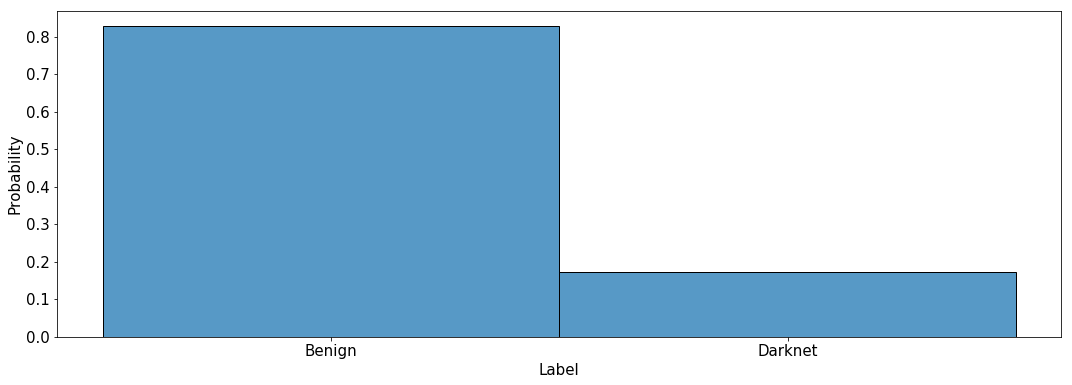

In [220]:
sns.histplot(data=to_analyse, x="Label", stat="probability")
plt.show()

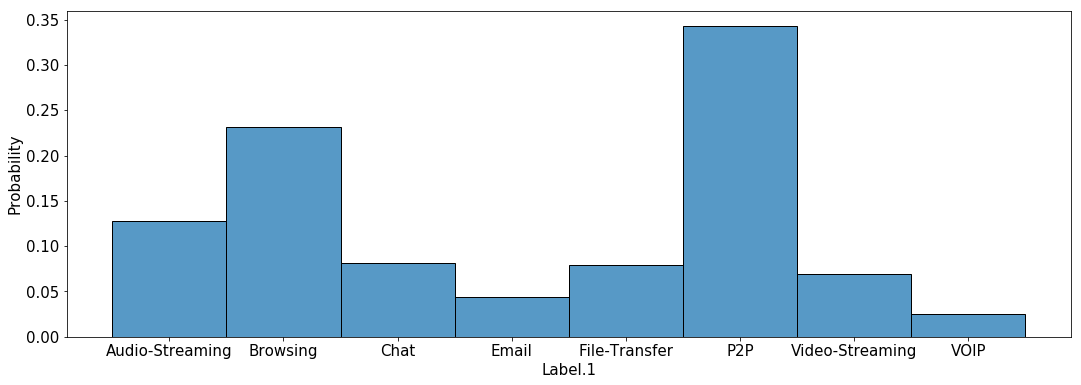

In [221]:
sns.histplot(data=to_analyse, x="Label.1", stat="probability")
plt.show()

## Traffic type on Darknet and outside

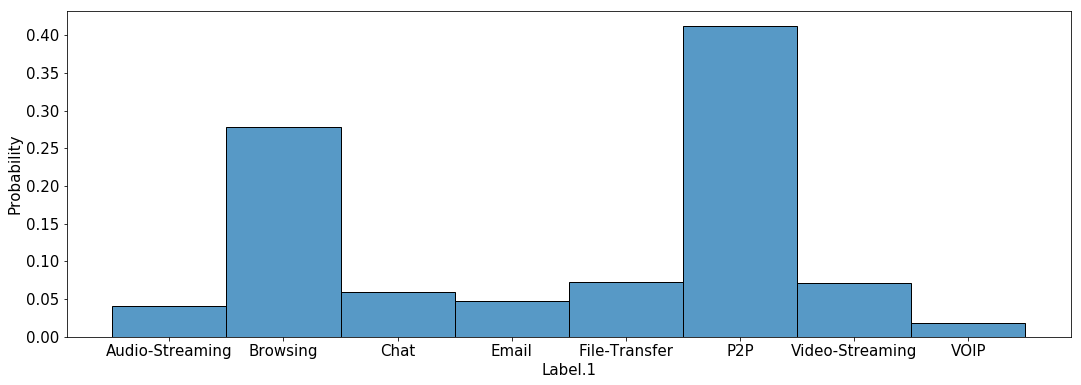

In [222]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Benign"], x="Label.1", stat="probability")
plt.show()

In [ ]:
to_analyse[to_analyse['Label'] == "Benign"]['Label.1'].hist(cumulative=True, density=1, bins=8, grid=True)
plt.show()

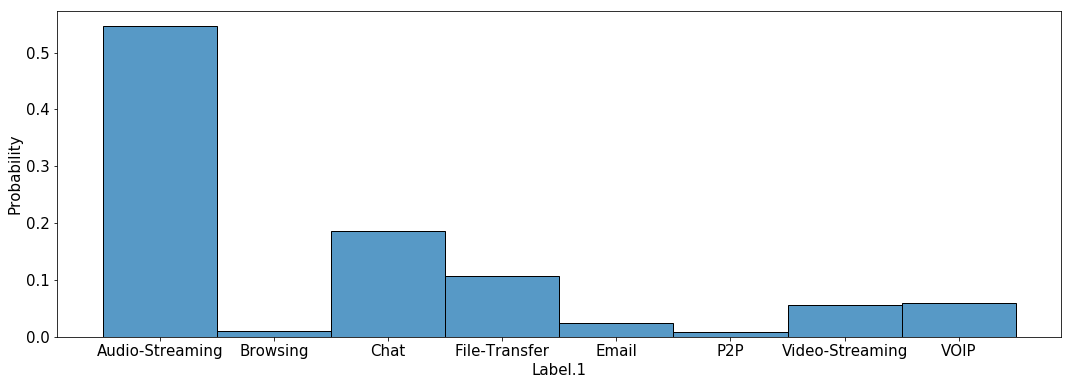

In [63]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Darknet"], x="Label.1", stat="probability")
plt.show()

In [ ]:
to_analyse[to_analyse['Label'] == "Darknet"]['Label.1'].hist(cumulative=True, density=1, bins=8, grid=True)
plt.show()

## Access hour

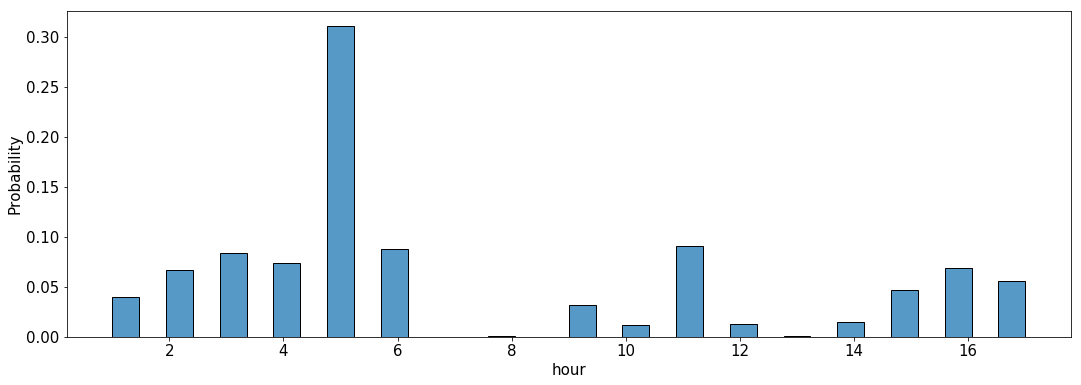

In [61]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Darknet"], x="hour", stat="probability")
plt.show()

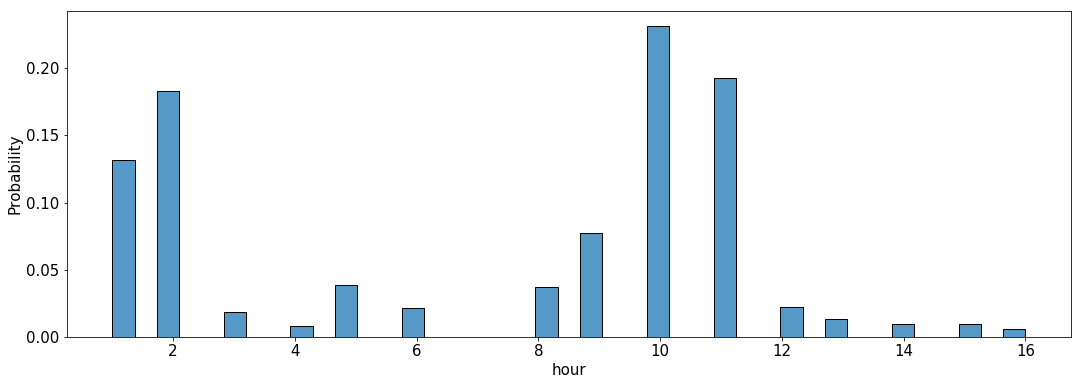

In [62]:
sns.histplot(data=to_analyse[to_analyse['Label'] == "Benign"], x="hour", stat="probability")
plt.show()

# Models evaluation

In [342]:
def kfold_validation(model, X, y, labels=None, n_splits=10, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    classifier_reports = []
    for train_index, test_index in tqdm(skf.split(X, y), total=n_splits): 
        x_train_fold, x_test_fold = X[train_index], X[test_index] 
        y_train_fold, y_test_fold = y[train_index], y[test_index] 
        model = model.fit(x_train_fold,y_train_fold)
        y_pred_fold = model.predict(x_test_fold)
        class_report = classification_report(y_test_fold, y_pred_fold, target_names=labels,
                                             output_dict=True)    
        classifier_reports.append(class_report)
    
    final_report = {}
    for report in classifier_reports:
        for label in report.keys():
            if type(report[label]) == dict:
                if label not in final_report:
                    final_report[label] = {}
                for key in report[label].keys():
                    if key not in final_report[label]:
                            final_report[label][key] = 0.0
                    final_report[label][key] += report[label][key]
            else:
                if label not in final_report:
                    final_report[label] = 0.0
                final_report[label] += report[label]

    for label in final_report.keys():
        if type(final_report[label]) == dict:
            for metric in final_report[label].keys():
                final_report[label][metric] /= n_splits
        else:
            final_report[label] /= n_splits
    final_report["n_splits"] = n_splits
    return final_report

In [343]:
def show_kfold_report(report, labels):
    metrics_printed = False
    n_spaces = max([len(label) for label in labels])
    for label in labels:
        if not metrics_printed:
            print(" "*n_spaces, end='')
            for metric in report[label].keys():
                print(f"{metric}", " "*6,end='')
            metrics_printed = True
            print()
        print(f"{label}: ", " "*(n_spaces-len(label)),end='')
        for metric in report[label].keys():
            print("%0.2f\t\t"%(report[label][metric]*100),end='')
        print()
    print("\n\n", "%d-fold Accuracy: %0.2f%%"%(report["n_splits"],report['accuracy']*100))

In [344]:
def show_confusion_matrix(model, X, y, labels):
    y_pred = model.predict(X)
    conf = confusion_matrix(y, y_pred)
    n_spaces = max([len(label) for label in labels])
    print("Test accuracy: %0.2f%%\n"%(np.sum((y_pred==y))/y.size*100))
    print("\nConfusion matrix:")
    print(conf)
    print()
    for i in range(conf.shape[0]):
        print(labels[i],":"," "*(n_spaces- len(labels[i])) ," %0.2f%%"%(conf[i,i]/np.sum(conf[i,:])*100))

## Benign vs Darknet classification

In [345]:
X = model_samples.copy()
del X["Label"]
X = X.values
y = model_samples["Label"].values
labels = np.unique(model_samples["Label"])

### Decision tree

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

In [347]:
model = DecisionTreeClassifier(random_state=random_state)
kfold_report = kfold_validation(model, X_train, y_train, labels=['Benign', 'Darknet'], n_splits=10)
show_kfold_report(kfold_report, labels)
show_confusion_matrix(model, X_test, y_test, labels)

100%|██████████| 10/10 [01:11<00:00,  7.16s/it]


       precision       recall       f1-score       support       
Benign:   99.94		99.92		99.93		784910.00		
Darknet:  99.64		99.71		99.67		163010.00		


 10-fold Accuracy: 99.89%
Test accuracy: 99.91%


Confusion matrix:
[[38661    18]
 [   22  7988]]

Benign :    99.95%
Darknet :   99.73%


## Darknet traffic caracterization

In [348]:
X1 = model_samples_l1[model_samples_l1["class_Darknet"] == 1].copy()
del X1["Label.1"]
del X1["class_Benign"]
del X1["class_Darknet"]
X1 = X1.values
y1 = model_samples_l1[model_samples_l1["class_Darknet"] == 1]["Label.1"].values
labels = np.unique(y1)

In [349]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.33, random_state=random_state)

### Decision tree

In [350]:
model = DecisionTreeClassifier(random_state=random_state)
kfold_report1 = kfold_validation(model, X1_train, y1_train, n_splits=10)
show_kfold_report(kfold_report1, np.unique(y1_train))
show_confusion_matrix(model, X1_test, y1_test, labels)

100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  99.60		99.66		99.63		88830.00		
Browsing:         93.05		83.82		87.85		1750.00		
Chat:             98.93		99.28		99.10		30520.00		
Email:            95.33		95.70		95.45		3930.00		
File-Transfer:    98.27		97.92		98.09		17300.00		
P2P:              97.12		96.25		96.48		1570.00		
VOIP:             97.39		97.97		97.68		9860.00		
Video-Streaming:  96.28		96.16		96.21		9120.00		


 10-fold Accuracy: 98.81%
Test accuracy: 99.03%


Confusion matrix:
[[4387    2   12    0    0    0    0    0]
 [   4   80    0    0    1    1    1    1]
 [   5    4 1479    0    0    0    1    0]
 [   0    0    0  184    5    0    0    0]
 [   1    0    0   11  864    0    0    4]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   2    0    1    0    4    2   10  415]]

Audio-Streaming :   99.68%
Browsing :          90.91%
Chat :              99.33%
Email :             97.35%
File-Tr

# Feature selection

## Recursive Feature Elimination (RFE)

In [353]:
model = DecisionTreeClassifier(random_state=random_state)
rfe = RFECV(model, step=2, cv=StratifiedKFold(10, shuffle=True), scoring='accuracy', n_jobs=4, verbose=3)
rfe.fit(X1, y1)

Fitting estimator with 184 features.
Fitting estimator with 182 features.
Fitting estimator with 180 features.
Fitting estimator with 178 features.
Fitting estimator with 176 features.
Fitting estimator with 174 features.
Fitting estimator with 172 features.
Fitting estimator with 170 features.
Fitting estimator with 168 features.
Fitting estimator with 166 features.
Fitting estimator with 164 features.
Fitting estimator with 162 features.
Fitting estimator with 160 features.
Fitting estimator with 158 features.
Fitting estimator with 156 features.
Fitting estimator with 154 features.
Fitting estimator with 152 features.
Fitting estimator with 150 features.
Fitting estimator with 148 features.
Fitting estimator with 146 features.
Fitting estimator with 144 features.
Fitting estimator with 142 features.
Fitting estimator with 140 features.
Fitting estimator with 138 features.
Fitting estimator with 136 features.
Fitting estimator with 134 features.
Fitting estimator with 132 features.
F

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
      estimator=DecisionTreeClassifier(random_state=42), n_jobs=4,
      scoring='accuracy', step=2, verbose=3)

In [359]:
print(f"Optimal number of features: {rfe.n_features_}")

Optimal number of features: 118


In [360]:
rfe.ranking_

array([34, 33, 32, 30, 29,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  4,  3,  7,  6,  9,  1,  1,  8,  5,  1,  1,  1,  1,  5,  1,
        9,  1,  1,  1,  1,  1,  1,  1,  1, 11,  1, 10,  4,  1, 12, 13, 14,
        1, 18, 18, 15, 17, 21, 21,  1,  1, 22,  1, 27, 23, 23, 27, 28, 25,
       12, 25, 19, 31, 20, 33,  1, 31, 28, 34,  1, 26, 24,  1, 26,  1,  1,
       22, 30, 29,  1,  1,  3,  1,  1, 32,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  7,  1,  1,  1,
        1,  1,  1, 11,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  6,  1, 14,  1,  1,  1,  1, 15,  8,  1,  1,  1, 17, 13,  2,
       10,  1,  1,  1, 16,  1, 20, 24, 16, 19,  1,  1,  1,  1])

In [361]:
X1_selected = rfe.transform(X1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_selected, y1, test_size=0.33, random_state=random_state)

In [362]:
kfold_report1 = kfold_validation(model, X1_train, y1_train, n_splits=10)
show_kfold_report(kfold_report1, np.unique(y1_train))
show_confusion_matrix(model, X1_test, y1_test, labels)

100%|██████████| 10/10 [00:05<00:00,  1.93it/s]

               precision       recall       f1-score       support       
Audio-Streaming:  99.61		99.68		99.65		88830.00		
Browsing:         94.56		87.32		90.61		1750.00		
Chat:             99.15		99.21		99.18		30520.00		
Email:            94.98		95.95		95.44		3930.00		
File-Transfer:    98.39		98.15		98.26		17300.00		
P2P:              97.21		96.88		96.86		1570.00		
VOIP:             97.49		98.07		97.77		9860.00		
Video-Streaming:  96.83		96.60		96.71		9120.00		


 10-fold Accuracy: 98.91%
Test accuracy: 99.04%


Confusion matrix:
[[4385    2   14    0    0    0    0    0]
 [   6   78    0    0    1    1    2    0]
 [   7    4 1477    0    0    0    1    0]
 [   0    0    0  186    3    0    0    0]
 [   0    0    0   10  867    0    0    3]
 [   0    0    0    0    0   63    0    0]
 [   0    0    1    0    0    0  473    5]
 [   0    0    2    0    4    2    9  417]]

Audio-Streaming :   99.64%
Browsing :          88.64%
Chat :              99.19%
Email :             98.41%
File-Tr

In [363]:
columns = model_samples_l1[model_samples_l1["class_Darknet"] == 1].columns.tolist()

In [364]:
if "Label.1" in columns:
    columns.remove("Label.1")
if "class_Benign" in columns:
    columns.remove("class_Benign")
if "class_Darknet" in columns:
    columns.remove("class_Darknet")

In [365]:
columns = [columns[i] for i in range(len(columns)) if rfe.support_[i]]
print(columns)

['col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31', 'col_32', 'col_33', 'col_34', 'col_41', 'col_42', 'col_45', 'col_46', 'col_47', 'col_48', 'col_50', 'col_52', 'col_53', 'col_54', 'col_55', 'col_56', 'col_57', 'col_58', 'col_59', 'col_61', 'col_64', 'col_68', 'col_75', 'col_76', 'col_78', 'col_91', 'col_95', 'col_98', 'hour', 'src_ip_country', 'Src Port', 'Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',

In [369]:
columns = zip(columns, model.feature_importances_)
for column, importance in columns:
    print(column, importance)

col_5 0.0020510719397541996
col_6 0.0
col_7 0.0
col_8 0.0
col_9 0.0001869625838004624
col_10 0.0
col_11 0.0
col_12 0.0
col_13 0.0
col_14 0.0
col_15 0.0
col_16 0.0
col_17 0.00018404129342858018
col_18 0.0027958740647802812
col_19 0.00016826632542041612
col_20 0.0
col_21 0.0
col_22 0.0
col_23 0.0
col_24 0.0
col_25 0.0
col_26 0.0
col_27 0.0
col_28 0.0
col_29 0.002306720271782207
col_30 0.0
col_31 0.0
col_32 0.0
col_33 0.00020973748543132203
col_34 0.0
col_41 0.0
col_42 0.000752344628081668
col_45 0.009287673685298802
col_46 0.0003590683194239236
col_47 0.0
col_48 0.00015774968008164014
col_50 0.0
col_52 0.0
col_53 0.00015598547117112347
col_54 0.0
col_55 0.0003125079375501341
col_56 0.0
col_57 0.0
col_58 0.03264653442376038
col_59 0.0
col_61 0.0002061075540772822
col_64 0.0
col_68 0.0
col_75 0.0004064059554645646
col_76 0.42865355644568065
col_78 0.0
col_91 0.0017934272331772629
col_95 0.0030674244802680103
col_98 0.0001574421758319684
hour 0.33294851077055804
src_ip_country 0.00033653265

In [324]:
dotfile = open("dtree2.dot", 'w')
export_graphviz(model, out_file = dotfile, feature_names = columns)
dotfile.close()